In [603]:
from src.database import DatabaseXRD,snip,Phase
from numpy import newaxis,loadtxt,diag,histogram,arange,linspace,sin,concatenate,array,exp,pi,zeros,ones,prod,newaxis,arctan,savetxt,c_,fabs,sqrt,concatenate
from numpy.random import normal
from numpy.linalg import pinv,inv
from scipy.optimize import curve_fit,least_squares
from scipy.interpolate import interp1d
from scipy.signal import find_peaks

from matplotlib.pyplot import plot,show,vlines,xlim,ylim,figure,semilogx,scatter,xlabel,ylabel,subplots,gca

from glob import glob

from scipy import signal
from numpy import fft,pad,concatenate,stack

from src.spectra import Spectra

In [604]:
database = DatabaseXRD().read_cifs('Database/')

calcite = database['Calcite'][0]
hydrocerussite = database['Hydrocerussite'][0]
cinnabar = database['Cinnabar'][2]
spinel = database['Spinel'][0]
barite = database['Barite'][0]

In [611]:
def fce_calibration(x,a,beta,s):
    return (arctan((x+a)/s)) * 180 / pi + beta

class MixPhase(Phase):
    def __init__(self,phases):
        self.phases = phases
        
    def get_theta(self,**kwargs):
        
        theta = []
        intensity = []
        
        for phase in self.phases:
            x,y = phase.get_theta(**kwargs)
            theta += [x]
            intensity += [y]
            
        return concatenate(theta),concatenate(intensity)
    
    def _vlines(self):
        x,y = self.get_theta()
        return x,0,y
    
class GaussNewton():
    
    def __init__(self,phase,spectra):
        self.phase = phase
        self.spectra = spectra
        
        self.mu,self.i = self.phase.get_theta(max_theta = 53,min_intensity = 0.1)
        
        self.n_channel = len(self.channel)
        
        self.params = ones(len(self) * 2)
        
        self.sigma2 = self.params[:len(self)]
        self.gamma = self.params[len(self):]
        
        self.sigma2[:] = 0.04
        
        self.scale = 1
    
    def __len__(self):
        return self.i.__len__()
        
    @property
    def theta(self):
        return self.spectra.theta
    
    @property
    def channel(self):
        return self.spectra.channel
    
    def core(self,x,mu,sigma2):
        return exp(-0.5 * (x - mu)**2 / sigma2)
    
    def ddsigma2(self,x,mu,sigma2):
        return 0.5 * (x - mu)**2 / sigma2**2
    
    def dda(self,channel,x,a,s,mu,sigma2):
        return -1.0 / sigma2 * 180 / pi * s / ((a + channel)**2 + s**2) * (x - mu)
    
    def dds(self,channel,x,a,s,mu,sigma2):
        return 1.0 / sigma2 * 180 / pi * (a + channel) / ((a + channel)**2 + s**2) * (x - mu)
    
    def ddbeta(self,x,mu,sigma2):
        return -1.0 / sigma2 * (x - mu)

    @property
    def z(self):     
        x = self.theta
        _z = zeros(self.n_channel)
        for mu,I,sigma2,gamma in zip(self.mu, self.i,
                                     self.sigma2, self.gamma):
            c = self.core(x,mu,sigma2)
            _z += gamma * I * c
            
        return _z * self.scale
    
    def _calibration(self):
        
        dopt = zeros((3,self.n_channel))     
        da,dbeta,ds = dopt[:]
        dgamma = []
        
        x = self.theta
        
        for mu,I,sigma2,gamma in zip(self.mu,self.i,
                                     self.sigma2,self.gamma):
            c = self.core(x,mu,sigma2)
            h = gamma * I * c
            
            dgamma += [I * c]
            
            da += h * self.dda(self.channel,x,*self.spectra.a,*self.spectra.s,mu,sigma2)
            dbeta += h * self.ddbeta(x,mu,sigma2)
            ds += h * self.dds(self.channel,x,*self.spectra.a,*self.spectra.s,mu,sigma2)
        
        return list(dopt) + dgamma
    
    def calibration(self,alpha = 1):

        y = self.spectra.intensity
        dopt = self._calibration()
        
        dz = y - self.z
        d = array(dopt).T
        
        dr = pinv(d) @ dz
   
        self.spectra.opt[:] += dr[:3] * alpha
        self.gamma[:] += dr[3:] * alpha
    
    def _min_gamma(self):
        
        dgamma = []
        x = self.theta
        
        for mu,I,sigma2,gamma in zip(self.mu,self.i,
                                     self.sigma2,self.gamma):
            c = self.core(x,mu,sigma2)
            dgamma += [I * c]
        
        return dgamma
    
    def min_gamma(self,alpha = 1):

        y = self.spectra.intensity
        dopt = self._min_gamma()
        
        z = self.z
        dz = y - z
        d = array(dopt).T
        
        dr = pinv(d) @ dz
   
        self.gamma[:] += dr * alpha

In [623]:
files = glob('Cappello/Cinnabar_Hydrocerussite/roi*.dat')
cnb_hcs = MixPhase([cinnabar,hydrocerussite])

xrd_gn = []
xrd_spectra = []

for file in files:
    
    spectra = Spectra(file)
    spectra.calibrate_from_file('Cappello/Calibrazione1.txt').convolve(1).snip()
    
    xrd_spectra += [spectra]
    xrd_gn += [GaussNewton(cnb_hcs,spectra)]

(0.0, 1.0)

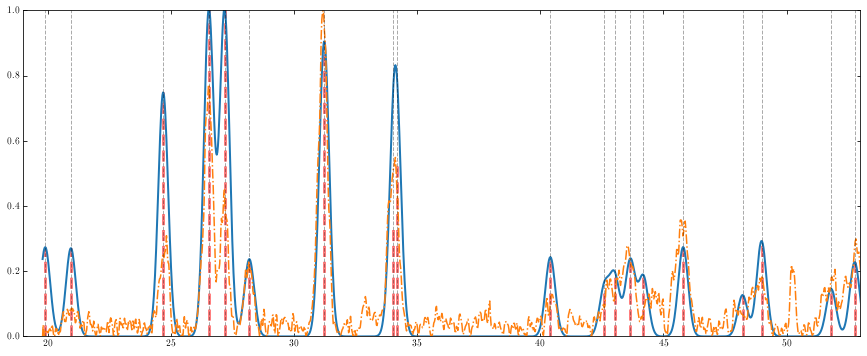

In [624]:
g = xrd_gn[0]
s = xrd_spectra[0]

figure(figsize=(15,6))

vlines(g.mu,0,g.i,'r',alpha=0.5,ls='--',lw=3)
plot(g.theta,g.z,'-',lw=2)
plot(s.theta,s.intensity,'-.')
vlines(g.mu,0,1,'k',alpha=0.33,ls='--',lw=1)


xlim(19,53)
ylim(0,1)

[-1164.15300792    50.18836033  1976.6756648 ]
[0.70848451 0.91245036 1.04428978 1.18174552 1.44398486 1.39906517
 1.29744207 0.07580239 0.34821452 0.36618287 0.36083639 0.79324136
 0.56660967 0.46983526 0.53848641 0.91321031 0.48909934 0.79335948
 0.66897242]
[-1171.55855743    50.81591644  1956.76998189]
[0.73299527 0.93589011 1.01146029 1.78537796 1.58607337 1.83297528
 1.46990487 0.09944296 0.3515593  0.26416398 0.30873    0.92263862
 0.43348711 0.53470754 0.2759889  0.91621598 0.55111325 0.79480691
 0.66367616]
[-1171.5643785     50.44693805  1967.40886079]
[0.79320199 0.81720016 1.04470752 1.36161096 1.31620691 1.19038868
 1.20877978 0.07299422 0.33408031 0.43033434 0.51524347 0.76851258
 1.0984855  0.52134961 0.33702461 1.36872275 0.73490505 0.94426402
 0.89390321]
[-1174.44619151    50.80783793  1963.470575  ]
[0.73425848 0.9716491  1.06638914 1.27325505 1.45412664 1.49222691
 1.25354672 0.10642826 0.21527115 0.21896146 0.27037531 0.93714482
 0.21747008 0.38656705 0.354565   0.

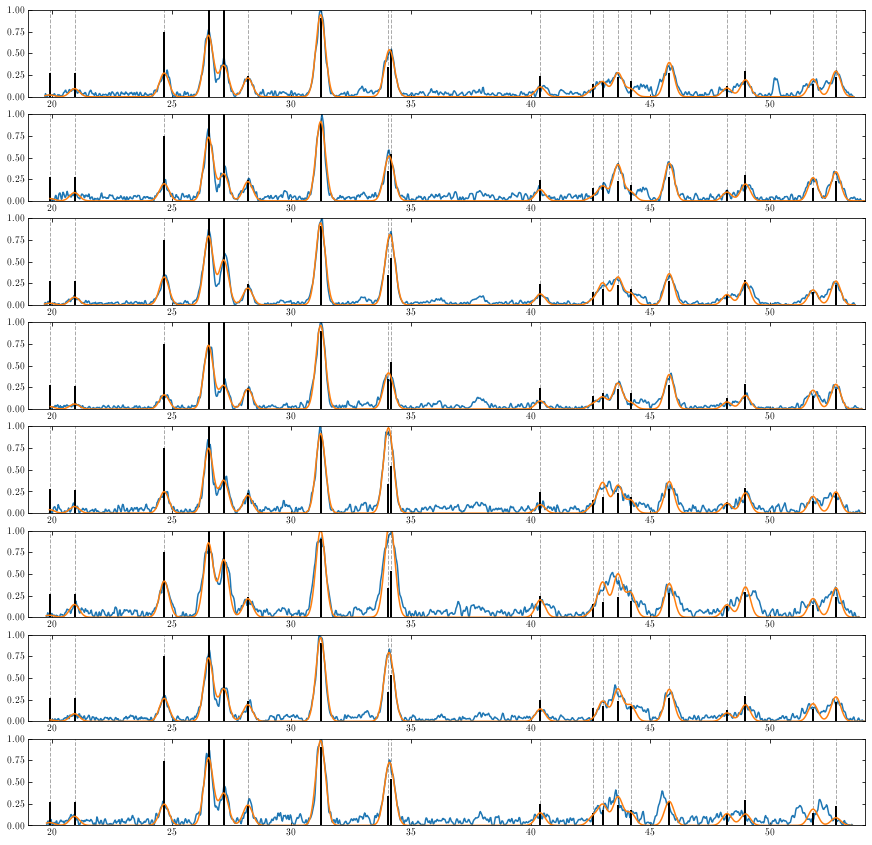

In [627]:
%matplotlib inline
fig,ax = subplots(len(xrd_spectra),1,figsize = (15,15))

for i,(spectra,gn) in enumerate(zip(xrd_spectra,xrd_gn)):
    
    for _ in range(16):
        gn.calibration(alpha=1)
    print(gn.spectra.opt)
    
    ax[i].plot(spectra.theta,spectra.intensity)
    
    x,y = cnb_hcs.get_theta(max_theta = 53,min_intensity=0.1)
    ax[i].vlines(x,0,y,'k',lw=2)
    ax[i].vlines(x,0,1.0,'k',lw=1,ls='--',alpha=0.33)
        
    ax[i].plot(gn.theta,gn.z)
    
    ax[i].set_xlim(19,54)
    ax[i].set_ylim(0,1)

[-1164.15299425    50.18835986  1976.67567803] [-1214.71937795    51.66346478  1952.71389334]
[-1171.5585574     50.81591644  1956.76998191] [-1214.71937795    51.66346478  1952.71389334]
[-1171.56436599    50.44693761  1967.4088731 ] [-1214.71937795    51.66346478  1952.71389334]
[-1174.44619076    50.8078379   1963.47057557] [-1214.71937795    51.66346478  1952.71389334]
[-1169.57486905    50.67633925  1961.95049419] [-1214.71937795    51.66346478  1952.71389334]
[-1170.79508727    50.56095004  1962.48091195] [-1214.71937795    51.66346478  1952.71389334]
[-1159.36691594    50.51438968  1959.91521512] [-1214.71937795    51.66346478  1952.71389334]
[-1005.04158632    45.66120602  2066.49474108] [-1214.71937795    51.66346478  1952.71389334]


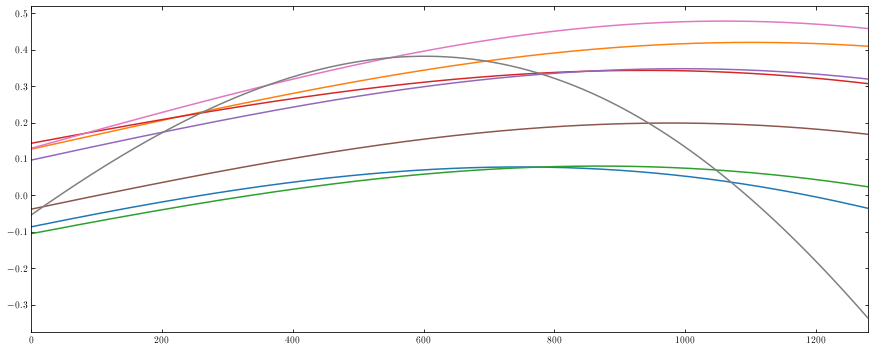

In [626]:
#fig,ax = subplots(len(xrd_spectra),1,figsize = (15,15))
figure(figsize=(15,6))

x = arange(0,1280)
for i,gn in enumerate(xrd_gn):
    opt = gn.spectra.opt
    opt_file = gn.spectra.opt_file
    print(opt,opt_file)
    
    y_new = fce_calibration(x,*opt)
    y_old = fce_calibration(x,*opt_file)
    
    plot(y_new-y_old)
    xlim(0,1280)
